## ``.sig_test.split_test`` in MNIST dataset

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as K
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
np.random.seed(0)
num_classes = 2
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.vstack((x_train, x_test))
y = np.hstack((y_train, y_test))
ind = (y == 9) + (y == 7)
X, y = X[ind], y[ind]
X = X.astype('float32')
X += .01*abs(np.random.randn(14251, 28, 28))
y[y==7], y[y==9] = 0, 1

if K.image_data_format() == 'channels_first':
	X = X.reshape(x.shape[0], 1, img_rows, img_cols)
	input_shape = (1, img_rows, img_cols)
else:
	X = X.reshape(X.shape[0], img_rows, img_cols, 1)
	input_shape = (img_rows, img_cols, 1)

X /= 255.

# convert class vectors to binary class matrices
y = keras.utils.to_categorical(y, num_classes)

In [5]:
## define the learning models
def cnn():
	model = Sequential()
	model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))
	model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.0005), metrics=['accuracy'])
	return model

model_null, model_alter = cnn(), cnn()

2022-06-29 16:58:55.239237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 16:58:55.243474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 16:58:55.243767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 16:58:55.244460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
## fitting param
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=15, restore_best_weights=True)

fit_params = {'callbacks': [es],
            'epochs': 50,
            'batch_size': 32,
            'validation_split': .2,
            'verbose': 0}

## testing params
test_params = { 'split': "one-split",
                'inf_ratio': None,
                'perturb': None,
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}

## tuning params
tune_params = { 'num_perm': 100,
                'ratio_grid': [.2, .4, .6, .8],
                'if_reverse': 0,
                'perturb_range': 2.**np.arange(-3,3,.1),
                'tune_ratio_method': 'fuse',
                'tune_pb_method': 'fuse',
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}

In [7]:
## Inference based on dnn_inference
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(19,28), np.arange(13,20)], [np.arange(21,28), np.arange(4, 13)],[np.arange(7,16), np.arange(9,16)]]
cue = split_test(inf_feats=inf_feats, model_null=model_null, model_alter=model_alter, eva_metric='zero-one')
P_value = cue.testing(X, y, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/06-29_16-59/model_null_init/assets


2022-06-29 16:59:00.569380: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved/split_test/06-29_16-59/model_alter_init/assets
====================== one-split for 0-th Hypothesis =======================


2022-06-29 16:59:02.617064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.020; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.26510; loss_null: 0.00140(0.03744); loss_alter: 0.00175(0.04185)
cv: 1; p_value: 0.68497; loss_null: 0.00211(0.04583); loss_alter: 0.00175(0.04185)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.795
====================== one-split for 1-th Hypothesis =======================
(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.16398; loss_null: 0.00140(0.03744); loss_alter: 0.00211(0.04583)
cv: 1; p_value: 0.92602; loss_null: 0.00316(0.05611); loss_alter: 0.00175(0.04185)
 🧪 1-th Hypothesis: accept H0 with p_value: 0.492
====================== one-split fo

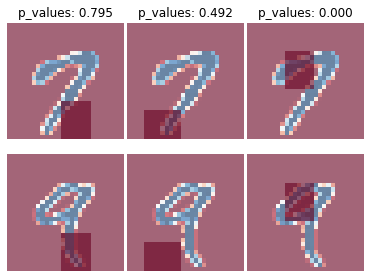

P-values: [0.7953140193691346, 0.49192858264606976, 1.1876805112986783e-19]


In [8]:
## visualize testing results
cue.visual(X,y)
print('P-values: %s' %P_value)